# $H \rightarrow \rho\gamma, \phi\gamma$ Analysis

In [110]:
# General imports
from copy import deepcopy
# Handling ROOT files
import json
import numpy as np
import uproot
from uproot_methods import TLorentzVectorArray
import pandas as pd
import pickle
# Machine Learning
from sklearn.metrics import roc_curve
import xgboost as xgb # BDT
# Custom
from analysis import Analysis
from tools import GetData, CombineYears, ScaleByCol, CombineScale1fbs
from config import config
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Get BDT and 2016, 2017, and 2018 Data

In [111]:
# Dataframes
dfs_2016 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2016/v4-0-0/", verbose=False)
dfs_2017 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2017/v4-0-0/", verbose=False)
dfs_2018 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2018/v4-0-0/", verbose=False)

# BDT
bst = pickle.load(open("bdt.pkl", "r")) # BDT model
with open("features.json", "r") as fin:
    features = json.load(fin) # BDT training/testing features
x_test = pd.read_pickle("x_test.pkl", compression="gzip") # Test dataset
preds_test = bst.predict(xgb.DMatrix(x_test[features]))

## Prepare Data: Before Combining Years

In [112]:
# Re-weight datasets with extensions
toReweight = {"2016": ["ttjets_sl_top", "ttjets_sl_tbar", "ttjets_dl", "wgamma", "dyjets"],
              "2017": ["dyjets"]}
dfs_years = {"2016": dfs_2016, "2017": dfs_2017, "2018": dfs_2018}
for year, names in toReweight.iteritems():
    dfs_year = dfs_years[year]
    for name in names:
        orig = name+year
        ext = name+"_ext"+year
        w_new = CombineScale1fbs(dfs_year[orig], dfs_year[ext], "scale1fb")
        dfs_year[orig]["scale1fb"] = w_new
        dfs_year[ext]["scale1fb"] = w_new

# Combine dataframes over all three years by sample
samples = ["ttg", "ttjets", "wjets", "wgamma", "dyjets", "data"]
regexps = ["^{}.*20.*$".format(mc) for mc in samples[:-1]] # Background sample naming scheme
regexps.append("^data_Run20..._(SingleMuon|SingleElectron|EGamma)_.*$") # Data naming scheme
dfs = CombineYears(dfs_years.values(), samples, regexps, signal=config["signal"], verbose=True)

# Make recoZ_mass column
for name, df in dfs.iteritems():
    lepton_p4 = TLorentzVectorArray.from_ptetaphim(df.recoWLepton_pt, df.recoWLepton_eta, df.recoWLepton_phi, 0.0) # m_lep ~ 0
    photon_p4 = TLorentzVectorArray.from_ptetaphim(df.recoGamma_pt, df.recoGamma_eta, df.recoGamma_phi, 0.0)
    Z_p4 = lepton_p4+photon_p4
    df["recoZ_mass"] = Z_p4.mass

Combining 4 dfs for wgamma
Combining 9 dfs for ttg
Combining 3 dfs for wjets
Combining 12 dfs for ttjets
Combining 5 dfs for dyjets
Combining 32 dfs for data


## Prepare Data: After Combining Years

In [113]:
# Scale relevant *_pt columns by Higgs mass
toScale = list(set(dfs["data"].columns[dfs["data"].columns.str.contains("_pt")])
               - set(["recoWLepton_pt", "met_pt"]))
dfs = ScaleByCol(dfs, toScale, "recoHiggs_mass")

In [114]:
# Analysis object handles plots, making cuts, etc.
analysis = Analysis(config, dfs, bst, features, verbose=True)

# Drop rho or phi events
if config["analysis"] == "rho":
    analysis.MakeCut("genHiggsMeson_id==113 or name!='whiggs'")
elif config["analysis"] == "phi":
    analysis.MakeCut("genHiggsMeson_id==333 or name!='whiggs'")
    
# Make general cuts
sanity = "scale1fb > -999 and recoWLepton_pt > 0 and recoPhi_pt > 0 and recoRho_pt > 0 and recoGamma_pt > 0"
doubleCount1 = "(genRecoGamma_isMatch == 1 and minGammaParton_dR > 0.2) or name not in ['wgamma', 'ttg']"
doubleCount2 = "(genRecoGamma_isMatch == 0 or minGammaParton_dR < 0.2) or name not in ['wjets', 'ttjets']"
ptCuts = "(recoWLepton_pt > 35 and abs(recoWLepton_id) == 11) or (recoWLepton_pt > 30 and abs(recoWLepton_id) == 13)"
hem = "isHEM == 0"
gold = "isGold == 1"
filters = "passFilters == 1"
analysis.MakeCut([sanity, doubleCount1, doubleCount2, ptCuts, hem, gold, filters])

## Get BDT Predictions

In [115]:
# Get BDT predictions
analysis.Predict()
# Blind the analysis from 120 < mass(H) < 130 GeV region
analysis_unblinded = deepcopy(analysis) # Save unblinded
analysis_blinded = deepcopy(analysis)
analysis_blinded.MakeCut("(recoHiggs_mass < 120 or recoHiggs_mass > 130) or isData == 0")

(0.30859940234128824, 0.93695533)


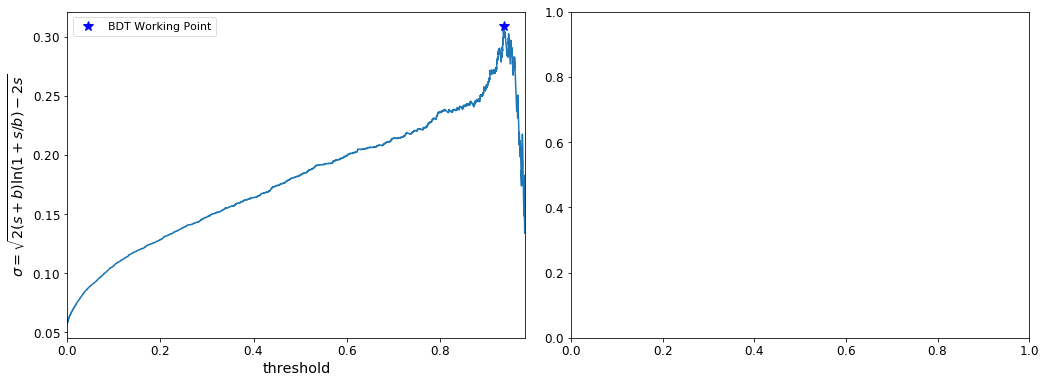

In [116]:
from matplotlib import pyplot as plt

# Subplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Get blindedd data and signal dataframes
data = analysis.dfs["data"]
sig = analysis.dfs["whiggs"]
# Add signal column
data["signal"] = 0
sig["signal"] = 1
# Restrict to interesting window
data = data[(data.recoHiggs_mass > 100) & (data.recoHiggs_mass < 180) & ((data.recoHiggs_mass < 120) | (data.recoHiggs_mass > 130))]
sig = sig[(sig.recoHiggs_mass > 100) & (sig.recoHiggs_mass < 180)]

combined = pd.concat([data, sig], sort=False)
fpr, tpr, thresh = roc_curve(combined.signal, combined.bdt)

# BDT Working Point vs. Efficiency
plt.subplot(1,2,1)
# Signal, background counts
counts = combined.signal.value_counts()
nSig = tpr*counts[1]*0.08330784*5e-4
nBg = fpr*counts[0]*(10.0/70)
# Prevent divide-by-zero errors
nonzero = (nBg != 0)
nSig = nSig[nonzero]
nBg = nBg[nonzero]
thresh = thresh[nonzero]
# Sigma
sigma = (2*(nSig+nBg)*np.log(1+nSig/nBg)-2*nSig)**0.5
# sigma = nSig/(3/2+nBg**0.5)
# Optimal points
test_bestEff = max(sigma)
test_bestBDT = thresh[np.argmax(sigma)]
# Plot
plt.plot(thresh, sigma)
plt.plot(test_bestBDT, test_bestEff, "b*", label="BDT Working Point", markersize=10);
# Settings
plt.xlabel("threshold");
plt.ylabel("$\sigma = \sqrt{2(s+b)\ln(1+s/b)-2s}$");
plt.legend();

print(test_bestEff, test_bestBDT)

Data/MC scale factor: 1.06400604801
Created bdt stacked plot.


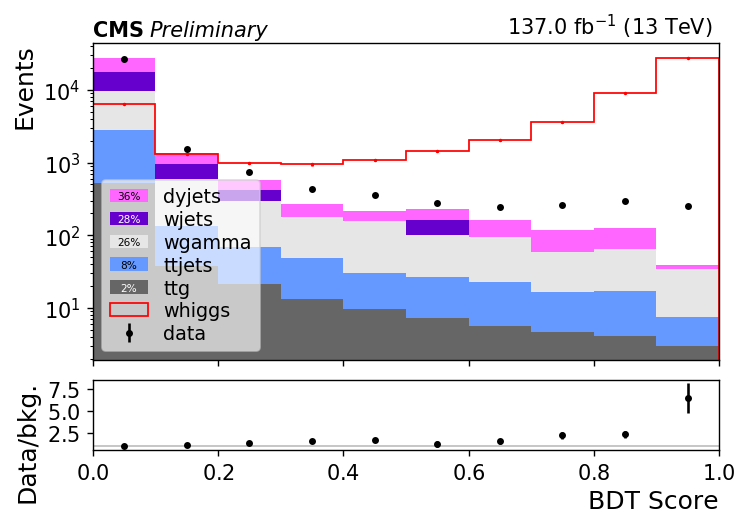

In [117]:
# Plot BDT scores by sample
analysis.Stacked("bdt", 10, 0, 1, xLabel=r"BDT Score", logY=True, save=False)

In [118]:
# Cut on BDT working point
# window = ((x_test.recoHiggs_mass>110) | (x_test.recoHiggs_mass<140))
# bestBDT = analysis.BestBDTCut(x_test, preds_test, window=window)
analysis_blinded.MakeBDTCut(test_bestBDT)
# analysis_blinded.MakeBDTCut(test_bestBDT)
# analysis_unblinded.MakeBDTCut(0.93695533)

## Results: Blinded

Data/MC scale factor: 11.2924867961
Created recoHiggs_mass stacked plot.


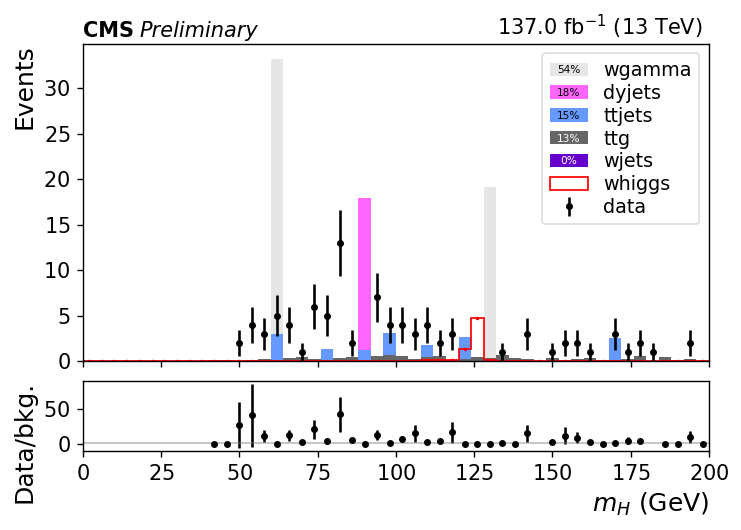

In [119]:
# Plots
analysis_blinded.Stacked("recoHiggs_mass", 50, 0, 200, xLabel=r"$m_{H}$ (GeV)", extra="_bdt",
                         sigWeight=0.08330784*5e-3, logY=False, overflow=False, save=False)

Data/MC scale factor: 11.4780517043
Created recoHiggs_mass stacked plot.


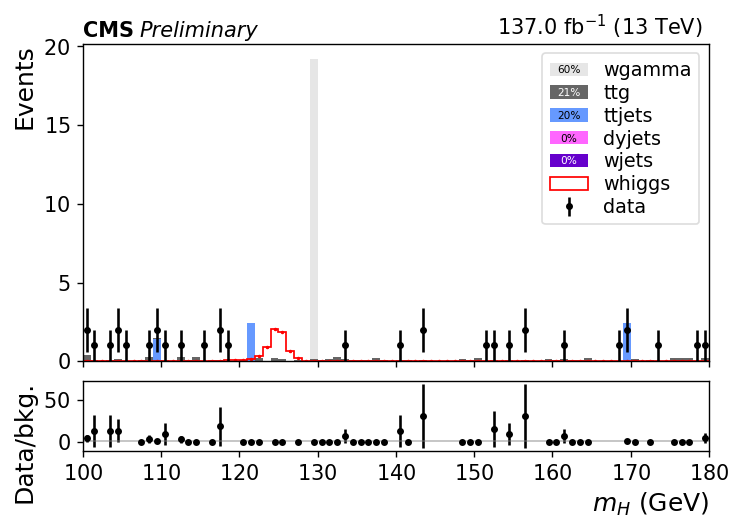

In [120]:
# Plots
analysis_blinded.Stacked("recoHiggs_mass", 80, 100, 180, xLabel=r"$m_{H}$ (GeV)", extra="_bdtZoom",
                         sigWeight=0.08330784*5e-3, logY=False, overflow=False, save=False)

In [131]:
region_data = analysis_blinded.dfs["data"]
region_data = region_data.loc[(region_data.recoHiggs_mass > 100) & (region_data.recoHiggs_mass < 180), "recoHiggs_mass"]

region_signal = analysis_blinded.dfs["whiggs"]
region_signal = region_signal.loc[(region_signal.recoHiggs_mass > 100) & (region_signal.recoHiggs_mass < 180), "recoHiggs_mass"]


with open("data.json", "w") as fout:
    json.dump(region_data.to_list(), fout)
with open("signal.json", "w") as fout:
    json.dump(region_signal.to_list(), fout)